In [0]:
!pip install tensorflow-gpu==2.0.0-beta1
import tensorflow as tf
from tensorflow import keras
tf.__version__

     |████████████████████████████████| 348.9MB 89kB/s 
     |████████████████████████████████| 501kB 43.0MB/s 
     |████████████████████████████████| 3.1MB 41.3MB/s 


'2.0.0-beta1'

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, MaxPooling1D
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, SpatialDropout1D

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem import SnowballStemmer
import string
import re
%matplotlib inline

In [0]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
def clean_text(text):
  text = text.translate(string.punctuation)
  
  text = text.lower().split()
  
  stops = set(nltk.corpus.stopwords.words('english'))
  text = [w for w in text if not w in stops and len(w) >= 3]
  
  text = " ".join(text)
  text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
  text = re.sub(r"what's", "what is ", text)
  text = re.sub(r"\'s", " ", text)
  text = re.sub(r"\'ve", " have ", text)
  text = re.sub(r"n't", " not ", text)
  text = re.sub(r"i'm", "i am ", text)
  text = re.sub(r"\'re", " are ", text)
  text = re.sub(r"\'d", " would ", text)
  text = re.sub(r"\'ll", " will ", text)
  text = re.sub(r",", " ", text)
  text = re.sub(r"\.", " ", text)
  text = re.sub(r"!", " ! ", text)
  text = re.sub(r"\/", " ", text)
  text = re.sub(r"\^", " ^ ", text)
  text = re.sub(r"\+", " + ", text)
  text = re.sub(r"\-", " - ", text)
  text = re.sub(r"\=", " = ", text)
  text = re.sub(r"'", " ", text)
  text = re.sub(r"\d+", " ", text)
  
  return text

In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip && unzip glove.6B.zip

--2019-07-31 19:10:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-07-31 19:10:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-07-31 19:10:35--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
vocabulary_size = 20000
tokenizer = Tokenizer(num_words=vocabulary_size)

In [0]:
embeddings_index = dict()
glove_file = open('glove.6B.300d.txt')
for line in glove_file:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
glove_file.close()

In [0]:
!wget https://raw.githubusercontent.com/ParakweetLabs/EmailIntentDataSet/master/src/resources/Ask0729-fixed.txt -O parakweet.txt

--2019-07-31 19:13:29--  https://raw.githubusercontent.com/ParakweetLabs/EmailIntentDataSet/master/src/resources/Ask0729-fixed.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347997 (340K) [text/plain]
Saving to: ‘parakweet.txt’

parakweet.txt       100%[===================>] 339.84K  --.-KB/s    in 0.04s   

2019-07-31 19:13:30 (7.85 MB/s) - ‘parakweet.txt’ saved [347997/347997]



In [0]:
data = pd.read_csv('parakweet.txt', header=None, delimiter='\t')
data.columns = ['label', 'content']
data['label'] = (data['label'] == 'Yes').astype(np.int)

In [0]:
data.head()

,label,content
0,0,>>> [1]Contact Me Now to Make $100 Today!$LINK
1,0,Act now to keep your life on the go!
2,0,Choose between $500 and $10000 dollars with up...
3,0,Click above to earn today.
4,0,Click here to receive your first $10 today:


In [0]:
data.loc[:, 'content'] = data.content.apply(clean_text)

In [0]:
data.head()

,label,content
0,0,contact make today ! link
1,0,act keep life go !
2,0,choose dollars years repay !
3,0,click earn today
4,0,click receive first today:


In [0]:
data.shape

(3657, 2)

In [0]:
data = data.sample(frac=1)
data, data_test = data.iloc[:3000, :], data.iloc[3000:, :]

In [0]:
tokenizer.fit_on_texts(data['content'])

In [0]:
sequences = tokenizer.texts_to_sequences(data['content'])
data_train = pad_sequences(sequences, maxlen=64)

In [0]:
embedding_matrix = np.zeros((vocabulary_size, 300))
for word, index in tokenizer.word_index.items():
  if index > vocabulary_size - 1:
    break
  else:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector

In [0]:
# Performs worse than LSTM
model = Sequential([
    Embedding(vocabulary_size, 300, input_length=64),
    Conv1D(64, 5, activation='relu'),
    SpatialDropout1D(0.2),
    MaxPooling1D(pool_size=4),
    LSTM(64, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [0]:
model = Sequential([
    Embedding(vocabulary_size, 100, input_length=64),
    LSTM(64),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [0]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 64, 100)           2000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_10 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 2,043,297
Trainable params: 2,043,297
Non-trainable params: 0
_________________________________________________________________


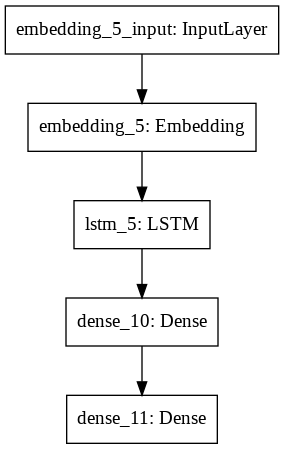

In [0]:
keras.utils.plot_model(model)

In [0]:
optimizer = keras.optimizers.Adam()
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [0]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [0]:
history = model.fit(data_train, data['label'], epochs=20, validation_split=0.1, batch_size=64, callbacks=[early_stop])

Train on 2700 samples, validate on 300 samples
Epoch 1/20
2700/2700 [==============================] - 2s 899us/sample - loss: 0.6852 - accuracy: 0.5956 - val_loss: 0.6594 - val_accuracy: 0.6833
Epoch 2/20
2700/2700 [==============================] - 1s 527us/sample - loss: 0.5217 - accuracy: 0.7833 - val_loss: 0.5477 - val_accuracy: 0.7500
Epoch 3/20
2700/2700 [==============================] - 1s 532us/sample - loss: 0.3160 - accuracy: 0.8870 - val_loss: 0.5834 - val_accuracy: 0.7433
Epoch 4/20
2700/2700 [==============================] - 1s 538us/sample - loss: 0.1905 - accuracy: 0.9315 - val_loss: 0.7280 - val_accuracy: 0.6967
Epoch 5/20
2700/2700 [==============================] - 1s 540us/sample - loss: 0.1174 - accuracy: 0.9656 - val_loss: 0.8099 - val_accuracy: 0.7100


In [0]:
tokenizer.fit_on_texts(data_test['content'])
sequences = tokenizer.texts_to_sequences(data_test['content'])
test = pad_sequences(sequences, maxlen=64)

model.evaluate(test, data_test['label'])

657/657 [==============================] - 0s 734us/sample - loss: 0.7319 - accuracy: 0.6271


[0.7319008140077693, 0.62709284]

In [0]:
predictions = model.predict(test)

In [0]:
preds = (predictions > 0.5).astype('int')

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
confusion_matrix(preds, data_test['label'])

array([[176,  88],
       [156, 237]])

In [0]:
dstext1 = 'Important email, please reply fast'
text2 = 'This is nothing.'
text1 = clean_text(text1)
text2 = clean_text(text2)

tokenizer.fit_on_texts([text2])
sequences = tokenizer.texts_to_sequences([text2])
text = pad_sequences(sequences, maxlen=64)

In [0]:
model.predict(text)

array([[0.6361075]], dtype=float32)

In [0]:
model.save('intent-model-lstm.h5')